In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from diffusion_equation import compute_solution
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

# Data from simulator

In [4]:
# # 2000
# sim_data = np.loadtxt("2000_data/sim_2k.txt", dtype=np.float32)
# x_list = np.loadtxt("2000_data/x_2k.txt", dtype=np.float32)
# y_list = np.loadtxt("2000_data/y_2k.txt", dtype=np.float32)
# t_list = np.loadtxt("2000_data/t_2k.txt", dtype=np.float32)
# sim_data, x_list, y_list, t_list

n_points = 1000
sim_r = np.random.randint(0, 5000, n_points)

# 5000
sim_data = np.loadtxt("data_5k_3sigma/sim_5000.txt", dtype=np.float32)[sim_r]
x_list = np.loadtxt("data_5k_3sigma/x_5000.txt", dtype=np.float32)[sim_r]
y_list = np.loadtxt("data_5k_3sigma/y_5000.txt", dtype=np.float32)[sim_r]
t_list = np.loadtxt("data_5k_3sigma/t_5000.txt", dtype=np.float32)[sim_r]
# sim_data, x_list, y_list, t_list

In [5]:
# nonlinear solution
# sim_nidexes = np.random.randint(0, 30_000, 5000)
# sim_data = np.loadtxt("data_100_nonlinear/sim_100.txt", dtype=np.float32)[sim_nidexes]

# x_list = np.loadtxt("data_100_nonlinear/x_100.txt", dtype=np.float32)[sim_nidexes]
# y_list = np.loadtxt("data_100_nonlinear/y_100.txt", dtype=np.float32)[sim_nidexes]
# t_list = np.loadtxt("data_100_nonlinear/t_100.txt", dtype=np.float32)[sim_nidexes]

# pwat_list = np.loadtxt("data_100_nonlinear/pwat_100.txt", dtype=np.float32)[sim_nidexes]
# poil_list = np.loadtxt("data_100_nonlinear/poil_100.txt", dtype=np.float32)[sim_nidexes]
# kwat_list = np.loadtxt("data_100_nonlinear/kwat_100.txt", dtype=np.float32)[sim_nidexes]
# koil_list = np.loadtxt("data_100_nonlinear/koil_100.txt", dtype=np.float32)[sim_nidexes]

In [6]:
perm = np.load('perm_3sigma.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

niter = 5000
t_final = 3.0
dt = t_final / niter

In [7]:
x = x_list * dx0
y = y_list * dx1
t = t_list * dt

points = np.stack((t, x, y), -1)

In [8]:
sim_data.shape

(1000, 3)

In [9]:
# # configuration of simulator
# # and parametrs of reservouir
# pwat = 2.0
# poil = 4.0
# vr = 0.3
# kwat = 1.0
# koil = 0.3


# pmin = 0.0
# pmax = 1.0
# nx0 = 50
# nx1 = 30
# nx2 = 1
# dx0 = 1.0 / nx0
# dx1 = 1.0 / nx1
# dx2 = 1.0 / nx2
# dt = 0
# niter = 100

# poro = 0.1 + np.zeros((nx0, nx1, nx2))
# perm = np.ones((nx0, nx1, nx2))

In [10]:
# configuration of simulator
# and parametrs of reservouir
# perm = np.load('perm_3sigma.npy')
# nx0, nx1 = perm.shape
# nx2 = 1
# perm = np.reshape(perm, (nx0, nx1, nx2))
# poro = 0.1 + np.zeros((nx0, nx1, nx2))

# dx0 = 1.0 / nx0
# dx1 = 1.0 / nx1
# dx2 = 1.0 / nx2

# pwat = 2.0
# poil = 4.0
# vr = 0.3
# kwat = 1.0
# koil = 0.3

# pmin = 0.0
# pmax = 1.0

# niter = 5000
# t_final = 3.0
# dt = t_final / niter

In [11]:
# dx0 = 1.0 / nx0
# dx1 = 1.0 / nx1
# dx2 = 1.0 / nx2

# x = np.array(x_list * dx0)
# y = np.array(y_list * dx1)
# t = np.array(t_list * dt)

# pwat1 = 2.0 * np.ones_like(x)
# poil1 = 4.0 * np.ones_like(x)
# kwat1 = 1.0 * np.ones_like(x)
# koil1 = 0.3 * np.ones_like(x)

# points = np.stack((t, x, y), -1)
# points, sim_data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    points, sim_data, test_size=0.33, random_state=42)

# Initialazing XGBoost model

In [13]:
xgb_regressor = xgb.XGBRegressor(tree_method='hist', verbosity=2)
multioutput_regressor = MultiOutputRegressor(xgb_regressor)
multioutput_regressor.fit(points, sim_data)

[13:48:02] INFO: /Users/runner/work/xgboost/xgboost/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1000, 3, 3000).
[13:48:03] INFO: /Users/runner/work/xgboost/xgboost/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1000, 3, 3000).
[13:48:03] INFO: /Users/runner/work/xgboost/xgboost/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (1000, 3, 3000).


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [14]:
mean_squared_error(multioutput_regressor.predict(points), sim_data)

5.180447715247283e-06

In [15]:
# mean_squared_error(multioutput_regressor.predict(X_test), y_test)

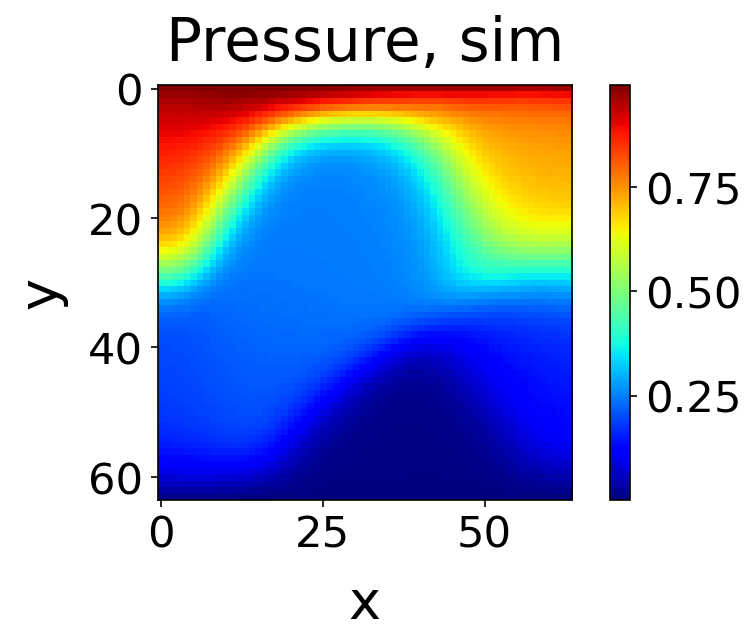

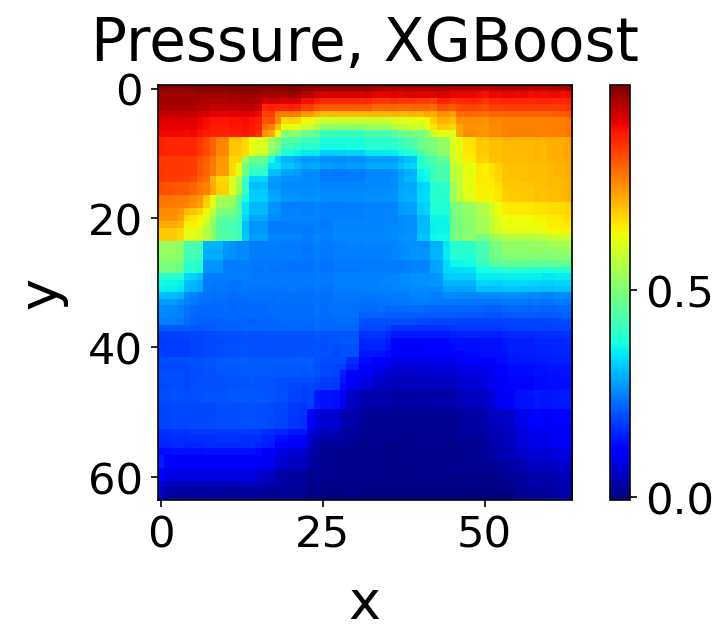

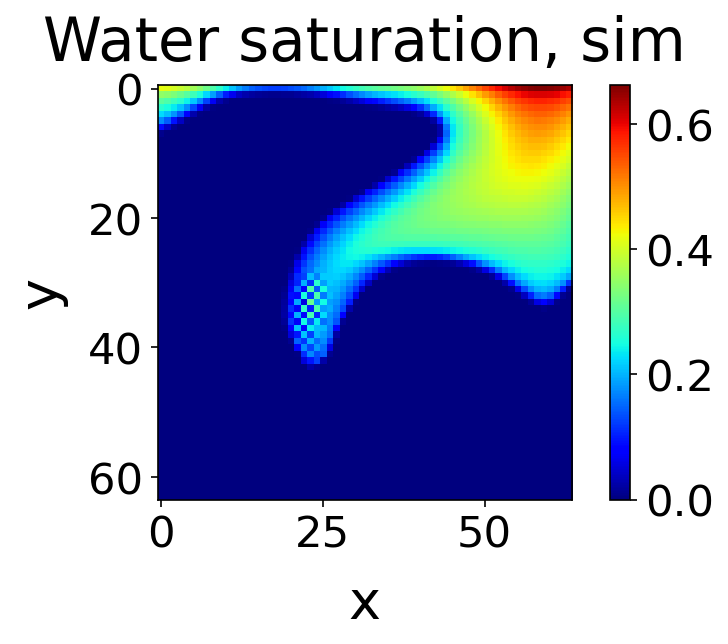

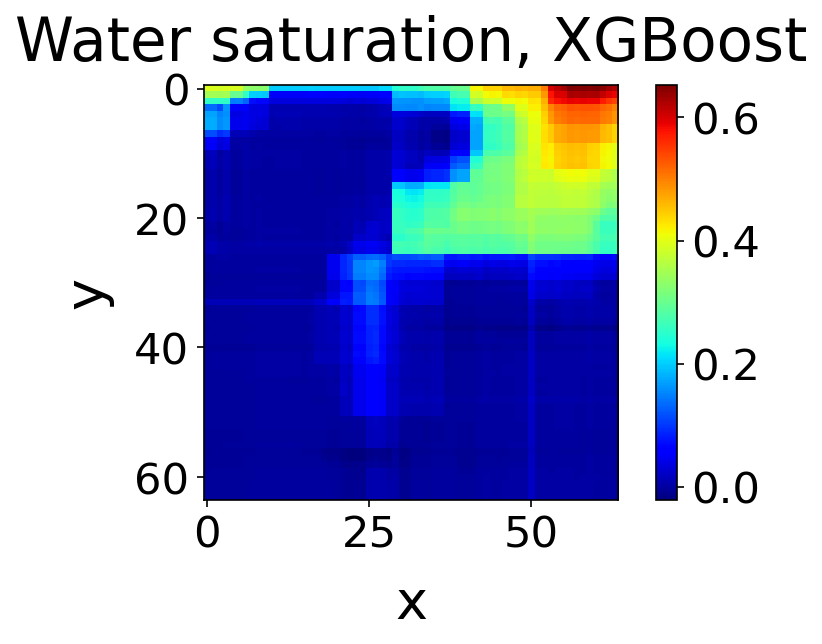

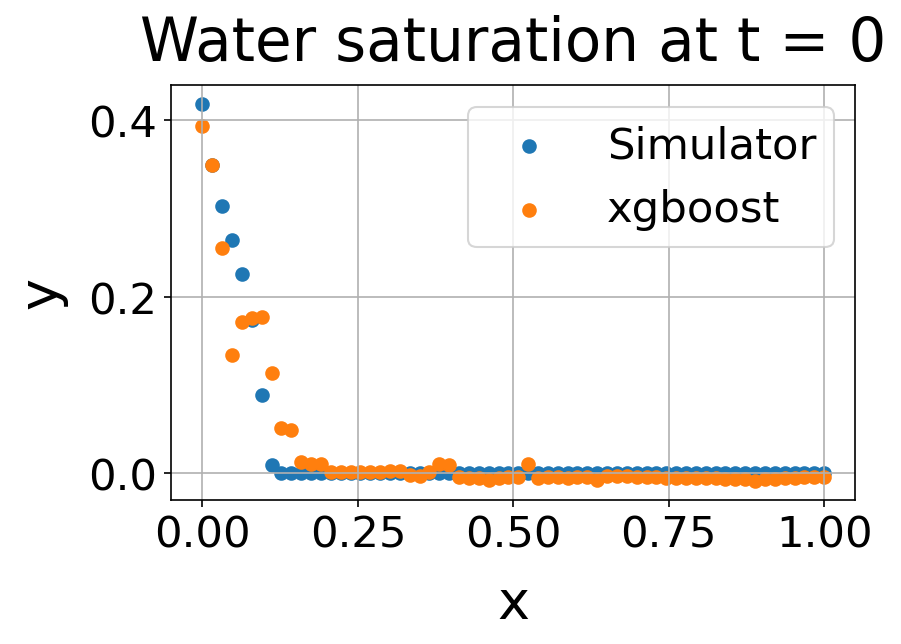

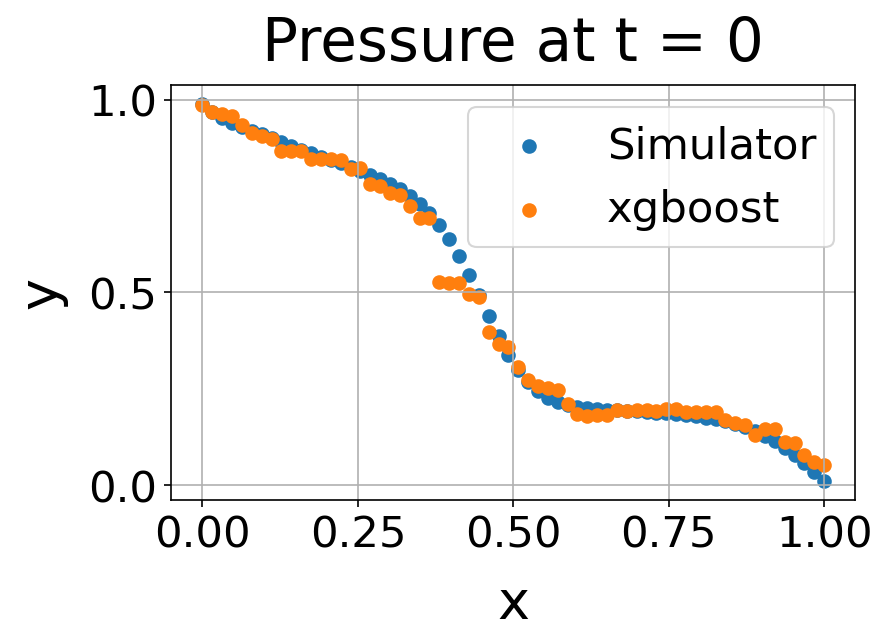

In [18]:
# pwat = 2.0
# poil = 4.0
# vr = 0.3
# kwat = 1.0
# koil = 0.3
# pmin = 0.0
# pmax = 1.0
# nx0 = 50
# nx1 = 30
# nx2 = 1
# dx0 = 1.0 / nx0
# dx1 = 1.0 / nx1
# dx2 = 1.0 / nx2
def set_big_plot_style(scale: float = 1.2):
    """Global matplotlib style for bigger text/ticks/legend and sharper saved figs."""
    base = 18 * scale
    title = 22 * scale
    label = 20 * scale
    ticks = 16 * scale
    legend = 16 * scale

    plt.rcParams.update({
        "figure.dpi": 150,
        "savefig.dpi": 300,

        "font.size": base,
        "axes.titlesize": title,
        "axes.labelsize": label,
        "xtick.labelsize": ticks,
        "ytick.labelsize": ticks,
        "legend.fontsize": legend,

        "axes.titlepad": 12,
        "axes.labelpad": 10,
    })

set_big_plot_style(scale=1.3)  # try 1.0 .. 1.6
perm = np.load('perm_3sigma.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

dt = 0.15e-1
niter = 100

# poro = 0.1 + np.zeros((nx0, nx1, nx2))
# perm = np.ones((nx0, nx1, nx2))

pres, swat, soil = compute_solution(perm, poro,
                                    dx0, dx1, dx2, dt * niter, niter,
                                    pwat, kwat, poil, koil, vr,
                                    pmin=0.0, pmax=1.0)

time_for_model = (niter * dt) * np.ones(64 * 64)
x_for_model = dx0 * torch.arange(64)
y_for_model = dx1 * torch.arange(64)
#     cartesian_points = np.transpose([np.tile(x_for_model, len(y_for_model)), 
#                                      np.repeat(y_for_model, len(x_for_model))])
cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
cartesian_points = cartesian_points.detach().numpy()
model_prediction = multioutput_regressor.predict(np.stack((
    time_for_model, 
    cartesian_points[:, 0], 
    cartesian_points[:, 1]), -1))


plt.figure()
plt.title('Pressure, sim')
plt.imshow(pres[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('third_test/color_pres_sim2.png', bbox_inches="tight")
plt.show()

plt.figure()
plt.title('Pressure, XGBoost')
plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('third_test/color_tree_pres2.png', bbox_inches="tight")
plt.show()



plt.figure()
plt.title('Water saturation, sim')
plt.imshow(swat[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

plt.figure()
plt.title('Water saturation, XGBoost')
plt.imshow(model_prediction[:, 1].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('third_test/color_tree_swat2.png', bbox_inches="tight")
plt.show()




plt.figure()
plt.title('Water saturation at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 1].reshape(nx0, nx1, nx2)[:, 0, 0], label='xgboost')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.legend()
plt.savefig('third_test/swat_scatter_tree2.png', bbox_inches="tight")
plt.show()


plt.figure()
plt.title('Pressure at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='xgboost')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.legend()
plt.savefig('third_test/pres_scatter_tree2.png', bbox_inches="tight")
plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

In [20]:
swat[:, :, :, -1].shape, model_prediction[:, 1].reshape(nx0, nx1, nx2).shape

((64, 64, 1), (64, 64, 1))

In [21]:
satur = [mean_squared_error(swat[:, :, :, -1].reshape(nx0, nx1), model_prediction[:, 1].reshape(nx0, nx1)),
         mean_absolute_error(swat[:, :, :, -1].reshape(nx0, nx1), model_prediction[:, 1].reshape(nx0, nx1)),
         r2_score(swat[:, :, :, -1].reshape(nx0, nx1), model_prediction[:, 1].reshape(nx0, nx1)),
         np.sqrt(mean_squared_error(swat[:, :, :, -1].reshape(nx0, nx1), model_prediction[:, 1].reshape(nx0, nx1)))]

pres_train = [mean_squared_error(pres[:, :, :, -1].reshape(nx0, nx1), model_prediction[:, 0].reshape(nx0, nx1)),
         mean_absolute_error(pres[:, :, :, -1].reshape(nx0, nx1), model_prediction[:, 0].reshape(nx0, nx1)),
         r2_score(pres[:, :, :, -1].reshape(nx0, nx1), model_prediction[:, 0].reshape(nx0, nx1)),
         np.sqrt(mean_squared_error(pres[:, :, :, -1].reshape(nx0, nx1), model_prediction[:, 0].reshape(nx0, nx1)))]

In [22]:
metrics_test = pd.DataFrame({'Saturation test': satur, 'Pressure test': pres_train}, index=['MSE', 'MAE', 'R^2', 'RMSE'])

In [23]:
metrics_test

,Saturation test,Pressure test
MSE,0.001802,0.000459
MAE,0.019812,0.013319
R^2,0.765318,0.993535
RMSE,0.042446,0.021418


In [24]:
# Train results
# pres, swat, soil

model_train_pred = multioutput_regressor.predict(points)
sim_data_train = sim_data

satur = [
    np.mean((model_train_pred[:, 1] - sim_data_train[:, 1]) ** 2),
    abs(np.mean(model_train_pred[:, 1] - sim_data_train[:, 1])),
    r2_score(sim_data_train[:, 1], model_train_pred[:, 1]),
    (np.mean((model_train_pred[:, 1] - sim_data_train[:, 1]) ** 2))**0.5
]


press = [
    np.mean((model_train_pred[:, 0] - sim_data_train[:, 0]) ** 2),
    abs(np.mean(model_train_pred[:, 0] - sim_data_train[:, 0])),
    r2_score(sim_data_train[:, 0], model_train_pred[:, 0]),
    (np.mean((model_train_pred[:, 0] - sim_data_train[:, 0]) ** 2))**0.5
]

In [25]:
metrics_train = pd.DataFrame({'Saturation train': satur, 'Pressure train': pres_train}, index=['MSE', 'MAE', 'R^2', 'RMSE'])
metrics_train

,Saturation train,Pressure train
MSE,5.366886e-06,0.000459
MAE,9.126961e-09,0.013319
R^2,9.997402e-01,0.993535
RMSE,2.316654e-03,0.021418


inside the main function


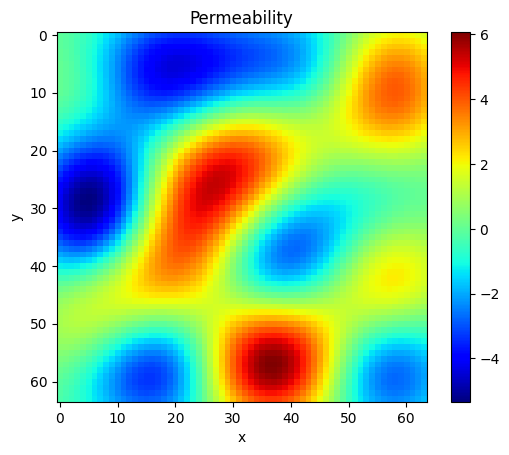

np.min(perm) = 0.004820015407051928
np.max(perm) = 433.05327115216323


0

In [38]:
def perm_fig():
    print('inside the main function')
#     nx0 = 64
#     nx1 = 64
#     lcor = 0.1
#     xdata = compute_mesh(nx0, nx1)
#     cmat = compute_cv_matrix(xdata, lcor)
#     log_perm = 1.0 * np.reshape(generate_random_field(cmat), (nx0, nx1))
    perm = np.load('perm_3sigma.npy')
    plt.figure()
    plt.title('Permeability')
    plt.imshow(np.log(perm))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('perm_field.png')
    plt.show()
    # np.save('log_perm.npy', log_perm)
    # perm = np.exp(log_perm)
    # np.save('perm.npy', perm)
    print('np.min(perm) = ' + str(np.min(perm)))
    print('np.max(perm) = ' + str(np.max(perm)))
    # eigh_val, eigh_vec = generate_random_field(cmat)
    # svec = eigh_vec[:, -1]
    # print(np.dot(cmat, svec) / svec)
    # print(eigh_val)
    return 0

perm_fig()

In [50]:
model_prediction[:, 1]

array([ 1.9126892e-01,  1.5244059e-01,  1.5244059e-01, ...,
       -4.1880845e-05,  3.9218302e-04,  3.9218302e-04], dtype=float32)

In [49]:
swat[...,-1].reshape(-1,)

array([ 3.02385884e-01,  2.93928023e-01,  2.82234111e-01, ...,
       -5.34482588e-38,  4.97197376e-37,  6.04828578e-37])